# Model Output File

Clean up the data and prep for modeling.
* Create time series
* Calculate distance to coast
* Create Holiday flag (window for 2 days before and 2 day after)
* Clean up missing values and create flags for imputed values if necessary

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import datetime
from datetime import datetime

import boto3
import awswrangler
# set name of S3 bucket
s3_bucket = 'traffic-data-bucket'

## 1. Create Boto3 session
Start by creating a boto3 session so that we can connect to the S3 bucket.

In [2]:
from aws_secrets import aws_access_key_id, aws_secret_access_key, aws_session_token

my_session = boto3.Session(
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    aws_session_token = aws_session_token

)

## 2. Import joined data set

In [4]:
import re

import os
from os.path import isfile, join
from pathlib import Path
from os import listdir
import os
os.getcwd()

#from commons import download_data, find_vcs_root

path =  Path(os.getcwd())
root = path.parent.absolute()

root

# joined_df = pd.read_csv(root / 'X.data' / 'model_data_pre_transformation.csv')

WindowsPath('C:/Users/emore/Documents/Michigan/MADS/SIADS 697 Capstone/Project/capstone')

In [5]:
joined_df = awswrangler.s3.read_parquet(path = f's3://{s3_bucket}/model_data/model_data_pre_transformation.parquet', boto3_session=my_session, use_threads=True)

In [6]:
joined_df.shape

(1950100, 133)

In [7]:
joined_df.sample(3)

,hex_id,collision_date,collision_year,collision_month,collision_dayofweek,collision_hour,accident_count,ttv_split,geometry,node_street_count,...,awnd,prcp,tavg,tmax,tmin,wdf2,amenities_restaurant_cnt,amenities_school_cnt,amenities_bar_cnt,amenities_college_cnt
230727,8829a1d661fffff,2014-04-24,2014,4,3,19,1,Validate,POLYGON ((-13165435.45724534 4032368.099946493...,5.0,...,6.93,0.0,64,73.0,56.0,270.0,NaN,2.0,NaN,1.0
833517,8829a0aee5fffff,2016-06-09,2016,6,3,19,0,Test,POLYGON ((-13112879.036236623 4029951.88188976...,3.0,...,7.61,0.0,63,68.0,60.0,250.0,NaN,NaN,NaN,NaN
373520,8829a56e47fffff,2018-02-02,2018,2,4,18,1,Train,POLYGON ((-13167402.542367423 4010037.20173677...,4.0,...,4.92,0.0,63,79.0,54.0,270.0,NaN,NaN,NaN,NaN


In [8]:
joined_df_copy = joined_df.copy()

Perform general exploration of the data

In [9]:
joined_df.accident_count.value_counts()

0    1561388
1     388712
Name: accident_count, dtype: Int64

In [10]:
joined_df.collision_year.value_counts().sort_index()

2014    253944
2015    274483
2016    302960
2017    305222
2018    303205
2019    293148
2020    217138
Name: collision_year, dtype: Int64

## 3. Creat time series features
### 3.1 Transform time series features into sin and cosin components

In [11]:
def cyclical_encode(data, col, max_val):
    data['drv_' + col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data['drv_' + col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

Inspect the variables

In [12]:
print('max and min hour')
print(np.max(joined_df.collision_hour))
print(np.min(joined_df.collision_hour))

print('max and min day of week')
print(np.max(joined_df.collision_dayofweek))
print(np.min(joined_df.collision_dayofweek))

print('max and min month')
print(np.max(joined_df.collision_month))
print(np.min(joined_df.collision_month))

max and min hour
23
0
max and min day of week
6
0
max and min month
12
1


In [13]:
sin_cos_transformed_list = {'collision_hour' : 23 ,
                            'collision_dayofweek' : 6, 
                            'collision_month' : 12
                           }

for date_type in sin_cos_transformed_list:
    joined_df = cyclical_encode(joined_df, date_type, sin_cos_transformed_list[date_type])

In [14]:
joined_df[['collision_hour', 'drv_collision_hour_sin', 'drv_collision_hour_cos']].sample(10)

,collision_hour,drv_collision_hour_sin,drv_collision_hour_cos
809030,2,0.519584,0.854419
1349908,14,-0.631088,-0.775711
227587,13,-0.398401,-0.917211
1841403,2,0.519584,0.854419
858359,18,-0.979084,0.203456
1934517,3,0.730836,0.682553
1716100,4,0.887885,0.460065
1820146,23,-0.0,1.0
1289998,21,-0.519584,0.854419
1743059,18,-0.979084,0.203456


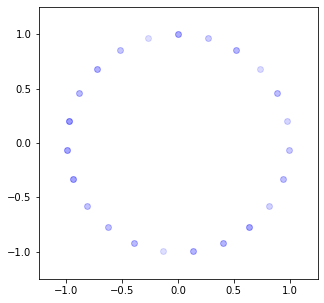

In [17]:
hour_tr_sample = joined_df[['collision_hour', 'drv_collision_hour_sin', 'drv_collision_hour_cos']].sample(500)

plt.rcParams["figure.figsize"] = [5.00, 5.00]
plt.plot(hour_tr_sample['drv_collision_hour_sin'], 
         hour_tr_sample['drv_collision_hour_cos'], 
         'o', 
         color='blue',
         alpha=.01);
plt.ylim(-1.25, 1.25);
plt.xlim(-1.25, 1.25);

### 3.2 Make a holiday indicator

In [18]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import datetime

cal = calendar()
dr = pd.date_range(start='2014-01-01', end='2020-12-31')
df = pd.DataFrame()
df['Date'] = dr

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

holiday_list = list()

for holiday in holidays:
    
    holiday = holiday.date()
    #print(holiday)
    date_plus1 = holiday + datetime.timedelta(days=1)
    date_plus2 = holiday + datetime.timedelta(days=2)
    date_minus1 = holiday + datetime.timedelta(days=-1)
    date_minus2 = holiday + datetime.timedelta(days=-2)
    
    holiday_list.append(date_minus2.strftime('%Y-%m-%d'))
    holiday_list.append(date_minus1.strftime('%Y-%m-%d'))
    holiday_list.append(holiday.strftime('%Y-%m-%d'))
    holiday_list.append(date_plus1.strftime('%Y-%m-%d'))
    holiday_list.append(date_plus2.strftime('%Y-%m-%d'))
    holiday_list.append(date_minus1.strftime('%Y-%m-%d'))
    holiday_list.append(date_minus2.strftime('%Y-%m-%d'))
    
holiday_list[0:10]


['2013-12-30',
 '2013-12-31',
 '2014-01-01',
 '2014-01-02',
 '2014-01-03',
 '2013-12-31',
 '2013-12-30',
 '2014-01-18',
 '2014-01-19',
 '2014-01-20']

Create a new column called `drv_holiday_flag` which indicates if the date of collision is a holiday.

In [19]:
joined_df['drv_holiday_flag'] = joined_df['collision_date'].isin(holiday_list)

In [20]:
joined_df['drv_holiday_flag'].value_counts()

False    1950100
Name: drv_holiday_flag, dtype: int64

## 4. Reduce dataset to selected columns

In [21]:
joined_df.columns[100:150]

Index(['collisions_neighbor_2_2014', 'collisions_neighbor_2_2015',
       'collisions_neighbor_2_2016', 'collisions_neighbor_2_2017',
       'collisions_neighbor_2_2018', 'collisions_neighbor_2_2019',
       'collisions_neighbor_2_2020', 'hex_neighbors_1_ids_y',
       'hex_neighbors_2_ids_y', 'curr_yr_coll_cnt', 'prev1_yr_coll_cnt',
       'prev2_yr_coll_cnt', 'prev1_yr_coll_neighbor1',
       'prev1_yr_coll_neighbor1_ave', 'prev1_yr_coll_neighbor2',
       'prev1_yr_coll_neighbor2_ave', 'prev2_yr_coll_neighbor1',
       'prev2_yr_coll_neighbor1_ave', 'prev2_yr_coll_neighbor2',
       'prev2_yr_coll_neighbor2_ave', 'station', 'name', 'date', 'awnd',
       'prcp', 'tavg', 'tmax', 'tmin', 'wdf2', 'amenities_restaurant_cnt',
       'amenities_school_cnt', 'amenities_bar_cnt', 'amenities_college_cnt',
       'drv_collision_hour_sin', 'drv_collision_hour_cos',
       'drv_collision_dayofweek_sin', 'drv_collision_dayofweek_cos',
       'drv_collision_month_sin', 'drv_collision_month_cos',


In [22]:
keep_cols_list = ['hex_id', 'collision_date', 'collision_year', 'collision_month',
                  'collision_dayofweek', 'collision_hour', 'accident_count', 'ttv_split',
                  'node_street_count', 
                  'node_stop', 
                  'node_traffic_signals',
                  'CITY_NAME', 
                  'edge_speed_kph_max',
                  'edge_speek_kph_min', 
                  'edge_lanes_max', 
                  'edge_motorway_id', 
                  'edge_motorway_link_id', 
                  'edge_living_street_id',
                  'edge_bridge_id', 
                  'edge_oneway_id', 
                  'edge_tunnel_id',
                  'amenities_bar_cnt',
                  'amenities_school_cnt',
                  'amenities_restaurant_cnt',
                  'amenities_college_cnt',
                  'prev1_yr_coll_cnt',
                  'prev2_yr_coll_cnt', 
                  'prev1_yr_coll_neighbor1',
                  'prev1_yr_coll_neighbor2',
                  'prev2_yr_coll_neighbor1',
                  'prev2_yr_coll_neighbor2',
                  'awnd', 'prcp', 'tavg', 'tmax', 'tmin',
                  'drv_collision_hour_sin','drv_collision_hour_cos', 
                  'drv_holiday_flag']

In [24]:
print("The number of columns to keep are:", len(keep_cols_list))

The number of columns to keep are: 39


In [25]:
pd.set_option("display.max_columns", None)
joined_trimmed_df = joined_df[keep_cols_list]
joined_trimmed_df.sample(3)

,hex_id,collision_date,collision_year,collision_month,collision_dayofweek,collision_hour,accident_count,ttv_split,node_street_count,node_stop,node_traffic_signals,CITY_NAME,edge_speed_kph_max,edge_speek_kph_min,edge_lanes_max,edge_motorway_id,edge_motorway_link_id,edge_living_street_id,edge_bridge_id,edge_oneway_id,edge_tunnel_id,amenities_bar_cnt,amenities_school_cnt,amenities_restaurant_cnt,amenities_college_cnt,prev1_yr_coll_cnt,prev2_yr_coll_cnt,prev1_yr_coll_neighbor1,prev1_yr_coll_neighbor2,prev2_yr_coll_neighbor1,prev2_yr_coll_neighbor2,awnd,prcp,tavg,tmax,tmin,drv_collision_hour_sin,drv_collision_hour_cos,drv_holiday_flag
762563,8829a1cb2bfffff,2015-10-21,2015,10,2,6,0,Train,3.0,0.0,0.0,Unincorporated,64.4,56.0,2.0,False,False,False,True,False,False,NaN,NaN,NaN,NaN,3.0,0.0,5.0,8.0,NaN,NaN,7.16,0.00,71,79.0,63.0,0.997669,-0.068242,False
381935,8829a56eedfffff,2018-02-09,2018,2,4,14,1,Test,4.0,0.0,1.0,Gardena,60.6,40.6,6.0,False,False,False,False,True,False,NaN,NaN,NaN,NaN,6.0,12.0,135.0,430.0,114.0,391.0,6.04,0.00,61,72.0,51.0,-0.631088,-0.775711,False
1257172,8829a1c213fffff,2017-02-03,2017,2,4,10,0,Train,5.0,1.0,15.0,Pasadena,96.0,104.6,6.0,True,True,False,True,True,True,2.0,NaN,36.0,NaN,30.0,35.0,166.0,350.0,196.0,383.0,5.14,0.33,57,61.0,54.0,0.398401,-0.917211,False


Rename column names.

In [27]:
joined_trimmed_df.rename(columns = {'awnd':'noaa_wind_speed' 
                                    ,'prcp':'noaa_precipitation'
                                    ,'tavg':'noaa_temperature_average'
                                    ,'tmax':'noaa_temperature_max'
                                    ,'tmin':'noaa_temperature_min'
                                    ,'wdf2':'noaa_wind_direction'
                                    ,'CITY_NAME':'la_data_city_name'
                                    ,'edge_motorway_id':'edge_motorway_flag' 
                                    ,'edge_motorway_link_id':'edge_motorway_link_flag'
                                    ,'edge_living_street_id':'edge_living_street_flag'
                                    ,'edge_bridge_id':'edge_bridge_flag' 
                                    ,'edge_oneway_id':'edge_oneway_flag'
                                    ,'edge_tunnel_id':'edge_tunnel_flag'
                                    ,'drv_holiday_id':'drv_holiday_flag'
                                   }, inplace = True)

C:\Users\emore\AppData\Local\Temp\ipykernel_22532\672488296.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joined_trimmed_df.rename(columns = {'awnd':'noaa_wind_speed'


In [28]:
joined_trimmed_df.columns

Index(['hex_id', 'collision_date', 'collision_year', 'collision_month',
       'collision_dayofweek', 'collision_hour', 'accident_count', 'ttv_split',
       'node_street_count', 'node_stop', 'node_traffic_signals',
       'la_data_city_name', 'edge_speed_kph_max', 'edge_speek_kph_min',
       'edge_lanes_max', 'edge_motorway_flag', 'edge_motorway_link_flag',
       'edge_living_street_flag', 'edge_bridge_flag', 'edge_oneway_flag',
       'edge_tunnel_flag', 'amenities_bar_cnt', 'amenities_school_cnt',
       'amenities_restaurant_cnt', 'amenities_college_cnt',
       'prev1_yr_coll_cnt', 'prev2_yr_coll_cnt', 'prev1_yr_coll_neighbor1',
       'prev1_yr_coll_neighbor2', 'prev2_yr_coll_neighbor1',
       'prev2_yr_coll_neighbor2', 'noaa_wind_speed', 'noaa_precipitation',
       'noaa_temperature_average', 'noaa_temperature_max',
       'noaa_temperature_min', 'drv_collision_hour_sin',
       'drv_collision_hour_cos', 'drv_holiday_flag'],
      dtype='object')

## 5. Check for missing values
Here we check for missing values in each column and if missing values are present, we will fill them with zero.

In [29]:
na_cnt = joined_trimmed_df.isnull().sum()
na_cnt[na_cnt>0]

edge_lanes_max               243020
amenities_bar_cnt           1814484
amenities_school_cnt        1049188
amenities_restaurant_cnt    1298788
amenities_college_cnt       1891871
prev1_yr_coll_cnt            216668
prev2_yr_coll_cnt            216668
prev1_yr_coll_neighbor1      446041
prev1_yr_coll_neighbor2      443549
prev2_yr_coll_neighbor1      691035
prev2_yr_coll_neighbor2      688812
dtype: int64

In [30]:
joined_trimmed_df.prev1_yr_coll_cnt = joined_trimmed_df.prev1_yr_coll_cnt.fillna(0)
joined_trimmed_df.prev2_yr_coll_cnt = joined_trimmed_df.prev2_yr_coll_cnt.fillna(0)
joined_trimmed_df.prev1_yr_coll_neighbor1 = joined_trimmed_df.prev1_yr_coll_neighbor1.fillna(0)
joined_trimmed_df.prev1_yr_coll_neighbor2 = joined_trimmed_df.prev1_yr_coll_neighbor2.fillna(0)
joined_trimmed_df.prev2_yr_coll_neighbor1 = joined_trimmed_df.prev2_yr_coll_neighbor1.fillna(0)
joined_trimmed_df.prev2_yr_coll_neighbor2 = joined_trimmed_df.prev2_yr_coll_neighbor2.fillna(0)
joined_trimmed_df.amenities_restaurant_cnt = joined_trimmed_df.amenities_restaurant_cnt.fillna(0)
joined_trimmed_df.amenities_bar_cnt = joined_trimmed_df.amenities_bar_cnt.fillna(0)
joined_trimmed_df.amenities_school_cnt = joined_trimmed_df.amenities_school_cnt.fillna(0)
joined_trimmed_df.amenities_college_cnt = joined_trimmed_df.amenities_college_cnt.fillna(0)


C:\Users\emore\AppData\Local\Temp\ipykernel_22532\3398034274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joined_trimmed_df.prev1_yr_coll_cnt = joined_trimmed_df.prev1_yr_coll_cnt.fillna(0)
C:\Users\emore\AppData\Local\Temp\ipykernel_22532\3398034274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joined_trimmed_df.prev2_yr_coll_cnt = joined_trimmed_df.prev2_yr_coll_cnt.fillna(0)
C:\Users\emore\AppData\Local\Temp\ipykernel_22532\3398034274.py:3: SettingWithCopyWarning: 
A value is trying to be se

Check if any columns contain missing values.

In [31]:
na_cnt = joined_trimmed_df.isnull().sum()
na_cnt[na_cnt>0]

edge_lanes_max    243020
dtype: int64

In [32]:
max_edge_mode = joined_trimmed_df.edge_lanes_max.value_counts().index[0]
max_edge_mode

5.0

In [33]:
joined_trimmed_df['drv_edge_lanes_max_imputed_flag'] = joined_trimmed_df['edge_lanes_max'].isna()

C:\Users\emore\AppData\Local\Temp\ipykernel_22532\4027621127.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joined_trimmed_df['drv_edge_lanes_max_imputed_flag'] = joined_trimmed_df['edge_lanes_max'].isna()


In [34]:
joined_trimmed_df['drv_edge_lanes_max_imputed_flag'].value_counts()

False    1707080
True      243020
Name: drv_edge_lanes_max_imputed_flag, dtype: int64

In [35]:
joined_trimmed_df.edge_lanes_max = joined_trimmed_df.edge_lanes_max.fillna(max_edge_mode)

C:\Users\emore\AppData\Local\Temp\ipykernel_22532\2474342085.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joined_trimmed_df.edge_lanes_max = joined_trimmed_df.edge_lanes_max.fillna(max_edge_mode)


In [36]:
#update true false id columns
for col in joined_trimmed_df.columns:
    if (col.endswith('_flag')):
        joined_trimmed_df.loc[joined_trimmed_df[col] == True, col] = 1
        joined_trimmed_df.loc[joined_trimmed_df[col] == False, col] = 0
        joined_trimmed_df[col] = joined_trimmed_df[col].astype('int')
        

C:\Users\emore\AppData\Local\Temp\ipykernel_22532\3063629062.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joined_trimmed_df[col] = joined_trimmed_df[col].astype('int')
C:\Users\emore\AppData\Local\Temp\ipykernel_22532\3063629062.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joined_trimmed_df[col] = joined_trimmed_df[col].astype('int')
C:\Users\emore\AppData\Local\Temp\ipykernel_22532\3063629062.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [37]:
joined_trimmed_df.sample(2)

,hex_id,collision_date,collision_year,collision_month,collision_dayofweek,collision_hour,accident_count,ttv_split,node_street_count,node_stop,node_traffic_signals,la_data_city_name,edge_speed_kph_max,edge_speek_kph_min,edge_lanes_max,edge_motorway_flag,edge_motorway_link_flag,edge_living_street_flag,edge_bridge_flag,edge_oneway_flag,edge_tunnel_flag,amenities_bar_cnt,amenities_school_cnt,amenities_restaurant_cnt,amenities_college_cnt,prev1_yr_coll_cnt,prev2_yr_coll_cnt,prev1_yr_coll_neighbor1,prev1_yr_coll_neighbor2,prev2_yr_coll_neighbor1,prev2_yr_coll_neighbor2,noaa_wind_speed,noaa_precipitation,noaa_temperature_average,noaa_temperature_max,noaa_temperature_min,drv_collision_hour_sin,drv_collision_hour_cos,drv_holiday_flag,drv_edge_lanes_max_imputed_flag
1147509,8829a19ab3fffff,2017-10-29,2017,10,6,3,0,Train,6.0,0.0,0.0,Los Angeles,75.6,40.2,8.0,0,0,0,1,1,0,1.0,0.0,2.0,0.0,18.0,14.0,36.0,113.0,32.0,104.0,5.82,0.00,64,71.0,61.0,0.730836,0.682553,0,0
359848,8829a56d8bfffff,2017-01-10,2017,1,1,8,1,Train,4.0,0.0,3.0,Los Angeles,60.6,40.6,4.0,0,0,0,0,0,0,0.0,4.0,0.0,0.0,39.0,41.0,250.0,607.0,256.0,610.0,7.61,0.09,56,59.0,51.0,0.81697,-0.57668,0,0


## 6. Review number of records in final dataset
Get count of records for train-test-validation

In [38]:
joined_trimmed_df.ttv_split.value_counts()

Train       974281
Test        585844
Validate    389975
Name: ttv_split, dtype: Int64

Get count of records for accident_count

In [39]:
joined_trimmed_df.accident_count.value_counts()

0    1561388
1     388712
Name: accident_count, dtype: Int64

In [40]:
#variable 3
var_numb = 7
#print(joined_trimmed_df.columns[var_numb])
for var_numb in range(len(joined_trimmed_df.columns)):
    if 'top' in joined_trimmed_df[joined_trimmed_df.columns[var_numb]].describe().index:
        print(joined_trimmed_df.columns[var_numb])
        print(var_numb)
        print(pd.DataFrame(joined_trimmed_df[joined_trimmed_df.columns[var_numb]].describe()))

hex_id
0
                 hex_id
count           1950100
unique             7199
top     8829a1d62dfffff
freq               1347
collision_date
1
       collision_date
count         1950100
unique           2557
top        2016-10-21
freq              947
ttv_split
7
       ttv_split
count    1950100
unique         3
top        Train
freq      974281
la_data_city_name
11
       la_data_city_name
count            1950100
unique                88
top          Los Angeles
freq              676006


In [41]:
joined_trimmed_df.describe()

,collision_year,collision_month,collision_dayofweek,collision_hour,accident_count,node_street_count,node_stop,node_traffic_signals,edge_speed_kph_max,edge_speek_kph_min,edge_lanes_max,edge_motorway_flag,edge_motorway_link_flag,edge_living_street_flag,edge_bridge_flag,edge_oneway_flag,edge_tunnel_flag,amenities_bar_cnt,amenities_school_cnt,amenities_restaurant_cnt,amenities_college_cnt,prev1_yr_coll_cnt,prev2_yr_coll_cnt,prev1_yr_coll_neighbor1,prev1_yr_coll_neighbor2,prev2_yr_coll_neighbor1,prev2_yr_coll_neighbor2,noaa_wind_speed,noaa_precipitation,noaa_temperature_average,noaa_temperature_max,noaa_temperature_min,drv_collision_hour_sin,drv_collision_hour_cos,drv_holiday_flag,drv_edge_lanes_max_imputed_flag
count,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1.950100e+06,1950100.0,1.950100e+06
mean,2.016963e+03,6.554335e+00,2.988787e+00,1.187062e+01,1.993293e-01,3.950189e+00,1.297372e+00,2.119589e+00,6.993084e+01,5.673378e+01,5.232270e+00,2.763033e-01,2.566089e-01,3.879288e-03,4.037860e-01,7.292329e-01,3.738731e-02,1.355597e-01,7.771796e-01,1.813981e+00,4.983847e-02,1.505155e+01,1.247683e+01,9.587181e+01,2.491354e+02,7.947659e+01,2.065025e+02,7.268674e+00,2.883028e-02,6.441166e+01,7.224361e+01,5.806708e+01,-4.613289e-02,-3.082251e-03,0.0,1.246193e-01
std,1.909940e+00,3.448210e+00,1.986621e+00,6.713805e+00,3.994962e-01,9.395294e-01,2.699720e+00,3.325300e+00,1.723489e+01,2.785199e+01,1.520317e+00,4.471687e-01,4.367618e-01,6.216302e-02,4.906557e-01,4.443562e-01,1.897090e-01,6.912530e-01,1.100237e+00,5.294563e+00,4.493792e-01,1.904082e+01,1.805566e+01,1.045840e+02,2.602693e+02,1.007638e+02,2.521159e+02,2.164386e+00,1.622393e-01,6.133886e+00,7.530544e+00,6.852858e+00,6.980649e-01,7.145406e-01,0.0,3.302868e-01
min,2.014000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00,1.290000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.240000e+00,0.000000e+00,4.700000e+01,5.300000e+01,3.600000e+01,-9.976688e-01,-9.906859e-01,0.0,0.000000e+00
25%,2.015000e+03,4.000000e+00,1.000000e+00,6.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,5.900000e+01,4.060000e+01,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00,2.700000e+01,0.000000e+00,0.000000e+00,5.820000e+00,0.000000e+00,6.000000e+01,6.700000e+01,5.300000e+01,-7.308360e-01,-7.757113e-01,0.0,0.000000e+00
50%,2.017000e+03,7.000000e+00,3.000000e+00,1.200000e+01,0.000000e+00,4.000000e+00,0.000000e+00,1.000000e+00,6.440000e+01,4.060000e+01,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,5.000000e+00,7.200000e+01,1.970000e+02,4.900000e+01,1.400000e+02,7.160000e+00,0.000000e+00,6.400000e+01,7.200000e+01,5.800000e+01,-2.449294e-16,-6.824241e-02,0.0,0.000000e+00
75%,2.019000e+03,1.000000e+01,5.000000e+00,1.800000e+01,0.000000e+00,4.000000e+00,1.000000e+00,3.000000e+00,8.850000e+01,1.017000e+02,6.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2.200000e+01,1.900000e+01,1.390000e+02,3.630000e+02,1.220000e+02,3.220000e+02,8.280000e+00,0.000000e+00,6.900000e+01,7.700000e+01,6.300000e+01,6.310879e-01,6.825531e-01,0.0,0.000000e+00
max,2.020000e+03,1.200000

## 7. Upload to S3

In [42]:
# awswrangler.s3.to_csv(df=joined_trimmed_df, path = 's3://traffic-data-bucket/model_data/model_data_post_transformation.csv', index=False,
#                        boto3_session=my_session, use_threads=True
#                        )


# awswrangler.s3.to_parquet(df=joined_trimmed_df, path = f's3://{s3_bucket}/model_data/model_data_post_transformation.parquet', index=False,
#                        boto3_session=my_session, use_threads=True
#                        )

{'paths': ['s3://traffic-data-bucket/model_data/model_data_post_transformation.parquet'],
 'partitions_values': {}}

In [ ]:
#create a local copy
joined_trimmed_df.to_csv(root / 'X.data' / 'model_data_post_transformation.csv', index = False )